In [2]:
#載入套件
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import math
import uuid
import random
import zipfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

In [3]:
# 分割x and y
def split_x_y(data_train,data_test,target="kredit"):

  train_y = data_train[target]
  train_x = data_train.drop(target, axis=1)

  test_x = data_test.drop(target, axis=1)
  test_y = data_test[target]

  return train_x, train_y, test_x, test_y

# 
def add_id(original_df):
  id = pd.Series(range(0,1000)).apply(lambda i : str(uuid.uuid4()))
  df_with_id = original_df.copy()
  df_with_id['id'] = id
  df_with_id = df_with_id.set_index('id')

  return df_with_id

def split_columns(df_with_id,columns_list,target):
  colum_1 = columns_list.copy()
  colum_1.append(target)
  colum_2 = columns_list.copy()
  # 分割欄位
  client1_data = df_with_id[colum_1]
  client2_data = df_with_id.drop(colum_2, axis=1)

  # 切割資料
  client1_train, client1_test = train_test_split(client1_data, test_size=0.2, random_state=0)
  client2_train, client2_test = train_test_split(client2_data, test_size=0.2, random_state=0)


  # 切割x,y
  client1_train_x,client1_train_y, client1_test_x, client1_test_y = split_x_y(client1_train,client1_test,target)
  client2_train_x,client2_train_y, client2_test_x, client2_test_y = split_x_y(client2_train,client2_test,target)

  # 找出共同的index
  common_train_index = client1_train.index.intersection(client2_train.index)
  common_test_index = client1_test.index.intersection(client2_test.index)

  return client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index

In [4]:
# model
# normalize data
def normalize_data(data):
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(np.array(data))
  return normalizer

In [5]:
#client
class Client:

  def __init__(self, train_data_x,train_data_y, test_data_x,test_data_y, labelled,model):
    self.__trainX = train_data_x.copy()
    self.__testX = test_data_x.copy()
    self.labelled = labelled
    self.__trainY = train_data_y.copy()
    self.__testY = test_data_y.copy()
    self.model = model
    
  def next_batch(self, index):
    self.batchX = self.__trainX.loc[index]

    if not self.labelled:
      grads = []
      self.model_output = np.zeros((len(index), 2))
      for i in range(len(index)):
        with tf.GradientTape() as gt:
          gt.watch(self.model.trainable_weights)
          output_by_example = self.model(self.batchX.iloc[i:i+1], training=True)
          output_for_grad = output_by_example[:,1]
        self.model_output[i] = output_by_example
        grads.append(gt.gradient(output_for_grad, self.model.trainable_weights))

      return grads
    
    else:
      self.batchY = self.__trainY.loc[index]
      with tf.GradientTape() as self.gt:
        self.gt.watch(self.model.trainable_weights)
        self.model_output = self.model(self.batchX, training=True)
  def cal_model(self):
    return self.model_output
  
  def predict(self, test_index):
    return self.model.predict(self.__testX.loc[test_index])# + 1e-8

  def predict_all(self, index):
    return self.model.predict(pd.concat([self.__trainX, self.__testX]).loc[index])

  def test_answers(self, test_index):
    if self.labelled:
      return self.__testY.loc[test_index]
    
  def test_answers_all(self, index):
    if self.labelled:
      return pd.concat([self.__testY, self.__trainY]).loc[index]
  
  def batch_answers(self):
    if self.labelled:
      return self.batchY

  def loss_and_update(self, a):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    self.prob = (a + self.model_output)/2
    self.c = self.coefficient_and_update()/len(self.batchX)
    return self.prob, loss_fn(self.batchY, self.prob)
  
  def coefficient_and_update(self):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    p = self.prob[:,1]
    c = (p-self.batchY)/((p)*(1-p))
    with self.gt:
      output = sum(c * self.model_output[:,1])/len(c)
    grads = self.gt.gradient(output, self.model.trainable_weights)
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
    return c
  
  def update_with(self, grads):
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

  def assemble_grad(self, partial_grads):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    # to assemble the gradient for client 1
    for i in range(len(self.c)):
      partial_grads[i] = [x * self.c[i] for x in partial_grads[i]]
    return [sum(x) for x in zip(*partial_grads)]
# 畫圖
# roc curve
def draw_roc_curve(fpr, tpr,auc):
  fig, ax = plt.subplots()
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()  


# 訓練圖
def plot_loss(loss, accuracy):
  fig, ax = plt.subplots()
  plt.plot(loss, label='loss')
  plt.plot(accuracy, label='accuracy')
  plt.xlabel('Epoch')
  # plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

# 準確率圖
def plot_accuracy(predictions, answers, threshold):
  tp, tn, fp, fn = 0, 0, 0, 0

  for x in range(len(predictions)):
    if answers[x] == 1:
      # if np.argmax(predictions[x]) == 1:
      if predictions[x][1] >= threshold:
        tp = tp + 1
      else:
        fn = fn + 1
    else:
      # if np.argmax(predictions[x]) == 0:
      if predictions[x][1] < threshold:
        tn = tn + 1
      else:
        fp = fp + 1
  
  accuracy = (tp + tn)/(tp + fp + fn + tn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  specificity = tn / (tn + fp)
  print("Accuracy: " + str(accuracy))
  print("Precision: " + str(precision))
  print("Recall: " + str(recall))
  # print("Specificity: " + str(specificity))
  print("F-Measure: " + str(2*(recall * precision) / (recall + precision)))

In [6]:
# 下載資料

# detect SouthGermanCredit file is exist or not
if not os.path.exists('./SouthGermanCredit'):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip

else:
  print('SouthGermanCredit file is exist')
  
with zipfile.ZipFile('SouthGermanCredit.zip', 'r') as zip_ref:
    zip_ref.extractall('./SouthGermanCredit/')

SouthGermanCredit file is exist


In [7]:
# 清理資料
original_df = pd.read_csv('./SouthGermanCredit/SouthGermanCredit.asc', sep=' ')
original_df.describe()
original_df=original_df.dropna()


# Normalize all columns
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(original_df)
original_df =pd.DataFrame(df_norm,columns=original_df.columns)

# choose target
target='kredit'
columns_list = ['rate',	'famges',	'buerge',	'wohnzeit',	'verm',	'alter',	'weitkred',	'wohn',	'bishkred',	'beruf'	,'pers'	,'telef',	'gastarb']
# 添加id
df_with_id = add_id(original_df)
# 切割資料
client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index = split_columns(df_with_id,columns_list=columns_list,target=target)
# 顯示訓練測試資料大小
print(
    'There are {} common entries (out of {}) in client 1 and client 2\'s training datasets,\nand {} common entries (out of {}) in their test datasets'
    .format(
        len(common_train_index),
        len(client1_train_x),
        len(common_test_index),
        len(client1_test_x)))

There are 800 common entries (out of 800) in client 1 and client 2's training datasets,
and 200 common entries (out of 200) in their test datasets


In [8]:
#vfl
# 設定參數
batch_size = 32
learning_rate = 1e-3
epochs = 50
num_folds = 5 

# merge train and test data
client1_input = pd.concat((client1_train_x,client1_test_x),axis=0)
client2_input = pd.concat((client2_train_x,client2_test_x),axis=0)
client1_target = pd.concat((client1_train_y,client1_test_y),axis=0)
client2_target = pd.concat((client2_train_y,client2_test_y),axis=0)

# get index
client1_input_index = client1_input.index.to_numpy()
client2_input_index = client2_input.index.to_numpy()
client1_target_index = client1_target.index.to_numpy()
client2_target_index = client2_target.index.to_numpy()


# Instantiate an optimizer.
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Instantiate a loss function.
# Not from logits because of the softmax layer converting logits to probability.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# define the kfold cross validation
kfold = KFold(n_splits=num_folds, shuffle=True)

In [9]:
# kfold cross validation evaluation of a model
fold_no =1

for (cen1_train_index, cen1_test_index), (cen2_train_index, cen2_test_index) in zip(
        kfold.split(client1_input_index, client1_target_index),
        kfold.split(client2_input_index, client2_target_index)):
  
  # index
  cen1_train_x_index = client1_input_index[cen1_train_index]
  cen2_train_x_index = client2_input_index[cen2_train_index]
  
  cen1_test_x_index = client1_input_index[cen1_test_index]
  cen2_test_x_index = client2_input_index[cen2_test_index]
  
  cen1_train_y_index = client1_target_index[cen1_train_index]
  cen2_train_y_index = client2_target_index[cen2_train_index]
  
  cen1_test_y_index = client1_target_index[cen1_test_index]
  cen2_test_y_index = client2_target_index[cen2_test_index]
  
  
  # define train,test x use index
  client1_train_x_k = client1_input[client1_input.index.isin(cen1_train_x_index)]
  client2_train_x_k = client2_input[client2_input.index.isin(cen2_train_x_index)]
  
  client1_test_x_k = client1_input[client1_input.index.isin(cen1_test_x_index)]
  client2_test_x_k = client2_input[client2_input.index.isin(cen2_test_x_index)]

  client1_train_y_k = client1_target[client1_target.index.isin(cen1_train_y_index)]
  client2_train_y_k = client2_target[client2_target.index.isin(cen2_train_y_index)]
  
  client1_test_y_k = client1_target[client1_target.index.isin(cen1_test_y_index)]
  client2_test_y_k = client2_target[client2_target.index.isin(cen2_test_y_index)]
  

  common_train_index_k = np.intersect1d(cen1_train_x_index,cen2_train_x_index)
  common_test_index_k = np.intersect1d(cen1_test_x_index,cen2_test_x_index)
  
  
  #init model
  normalizer1 = normalize_data(client1_train_x_k.loc[common_train_index_k])
  model1 =   tf.keras.Sequential([
        normalizer1,
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(2),
        layers.Softmax()])
  model1.summary()
  client1 = Client( client1_train_x_k, client1_train_y_k,client1_test_x_k,client1_test_y_k, False,model1)


  normalizer2 = normalize_data(client2_train_x_k.loc[common_train_index_k])
  model2 = tf.keras.Sequential([
        normalizer2,
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(2),
        layers.Softmax()])
  client2 = Client(client2_train_x_k, client2_train_y_k,client2_test_x_k,client2_test_y_k, True,model2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               1792      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              P

run in 0 epoch
-----train accuracy0.5842349529266357-----
run in 1 epoch
-----train accuracy0.7326120734214783-----
run in 2 epoch
-----train accuracy0.7387944459915161-----
run in 3 epoch
-----train accuracy0.7403400540351868-----
run in 4 epoch
-----train accuracy0.760432779788971-----
run in 5 epoch
-----train accuracy0.7496135830879211-----
run in 6 epoch
-----train accuracy0.7387944459915161-----
run in 7 epoch
-----train accuracy0.7527047991752625-----
run in 8 epoch
-----train accuracy0.7542504072189331-----
run in 9 epoch
-----train accuracy0.7496135830879211-----
run in 10 epoch
-----train accuracy0.7310664653778076-----
run in 11 epoch
-----train accuracy0.7496135830879211-----
run in 12 epoch
-----train accuracy0.7202472686767578-----
run in 13 epoch
-----train accuracy0.7619783878326416-----
run in 14 epoch
-----train accuracy0.7418856024742126-----
run in 15 epoch
-----train accuracy0.755795955657959-----
run in 16 epoch
-----train accuracy0.7480680346488953-----
run in 17

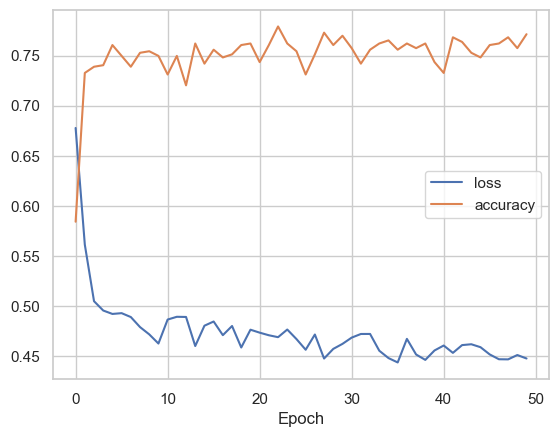

In [10]:
  # train_on_client
  common_train_index_list_k = common_train_index_k.tolist()
  epoch_loss = []
  epoch_acc = []

  for epoch in range(epochs):
      print(f'run in {epoch} epoch')
      # epoch=0
      random.shuffle(common_train_index_list_k)
      train_index_batches = [common_train_index_list_k[i:i + batch_size] for i in range(0, len(common_train_index_list_k), batch_size)] 
      total_loss = 0.0
      # Iterate over the batches of the dataset.
      for step, batch_index in enumerate(train_index_batches):
          
          partial_grads = client1.next_batch(batch_index)
          client2.next_batch(batch_index)

          prob, loss_value = client2.loss_and_update(client1.cal_model())
          grad = client2.assemble_grad(partial_grads)
          client1.update_with(grad)
          
          total_loss = loss_value + total_loss
          train_acc_metric.update_state(client2.batch_answers(), prob)
      train_acc = train_acc_metric.result()
      print(f'-----train accuracy{train_acc}-----')
      train_acc_metric.reset_states()
      epoch_loss.append((total_loss)/(step + 1))
      epoch_acc.append(train_acc)

  plot_loss(epoch_loss, epoch_acc)

2/2 [==============================] - 0s 2ms/step


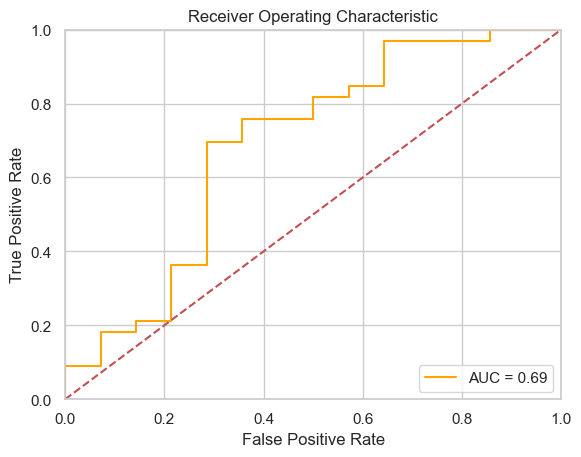

AUC: 0.6883116883116883
Best Threshold=0.539463, G-Mean=0.706

Accuracy: 0.7021276595744681
Precision: 0.8518518518518519
Recall: 0.696969696969697
F-Measure: 0.7666666666666667


In [11]:
  # 預測結果
  vfl_pred_test = (client1.predict(common_test_index_k) + client2.predict(common_test_index_k))/2

  # 計算roc,auc
  vfl_fpr_test, vfl_tpr_test, vfl_thresholds_test = roc_curve(client2.test_answers(common_test_index_k), vfl_pred_test[:,1])
  auc1 = auc(vfl_fpr_test, vfl_tpr_test)
  draw_roc_curve(vfl_fpr_test, vfl_tpr_test,auc1)
  print("AUC: {}".format(auc1 ))

  # 計算threshold 值
  vfl_gmeans_test = np.sqrt(vfl_tpr_test * (1-vfl_fpr_test))
  vfl_ix_test = np.argmax(vfl_gmeans_test)
  best_threshold = vfl_thresholds_test[vfl_ix_test]
  print('Best Threshold=%f, G-Mean=%.3f\n' % (vfl_thresholds_test[vfl_ix_test], vfl_gmeans_test[vfl_ix_test]))

  # 準確率
  plot_accuracy(vfl_pred_test, client2.test_answers(common_test_index_k), best_threshold)

  # save result
  df=pd.DataFrame(client2.test_answers(common_test_index_k))
  vfl_pred_test_label = [1 if p >= best_threshold else 0 for p in  vfl_pred_test[:,1]]
  df['predict']=vfl_pred_test_label
  df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')
  #evalueate

In [12]:
# ----------------------------------centralized----------------------------

In [13]:
# 設定參數
batch_size = 32
learning_rate = 1e-3
epochs = 20

# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

Epoch 1: Loss=2.1926, Accuracy=0.5688
Epoch 2: Loss=1.9147, Accuracy=0.6625
Epoch 3: Loss=1.7227, Accuracy=0.6662
Epoch 4: Loss=1.5612, Accuracy=0.6762
Epoch 5: Loss=1.4513, Accuracy=0.6812
Epoch 6: Loss=1.3450, Accuracy=0.6913
Epoch 7: Loss=1.2546, Accuracy=0.6837
Epoch 8: Loss=1.1794, Accuracy=0.6938
Epoch 9: Loss=1.1073, Accuracy=0.6950
Epoch 10: Loss=1.0569, Accuracy=0.7125
Epoch 11: Loss=0.9977, Accuracy=0.7088
Epoch 12: Loss=0.9651, Accuracy=0.7038
Epoch 13: Loss=0.9196, Accuracy=0.7138
Epoch 14: Loss=0.8845, Accuracy=0.7113
Epoch 15: Loss=0.8505, Accuracy=0.7075
Epoch 16: Loss=0.8207, Accuracy=0.7125
Epoch 17: Loss=0.8134, Accuracy=0.6975
Epoch 18: Loss=0.7906, Accuracy=0.7038
Epoch 19: Loss=0.7624, Accuracy=0.7050
Epoch 20: Loss=0.7350, Accuracy=0.7200
7/7 - 0s - loss: 0.7837 - accuracy: 0.6850 - 152ms/epoch - 22ms/step

Test accuracy: 0.6850000023841858
7/7 [==============================] - 0s 1ms/step


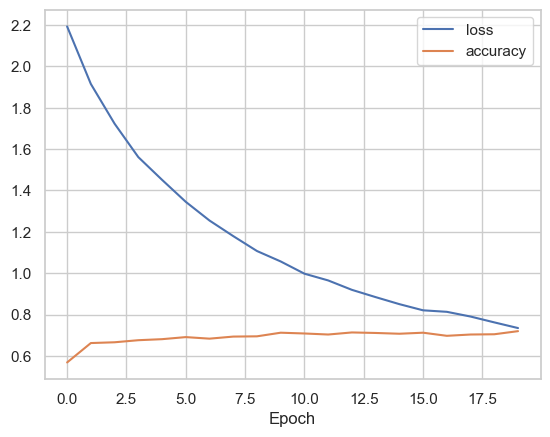

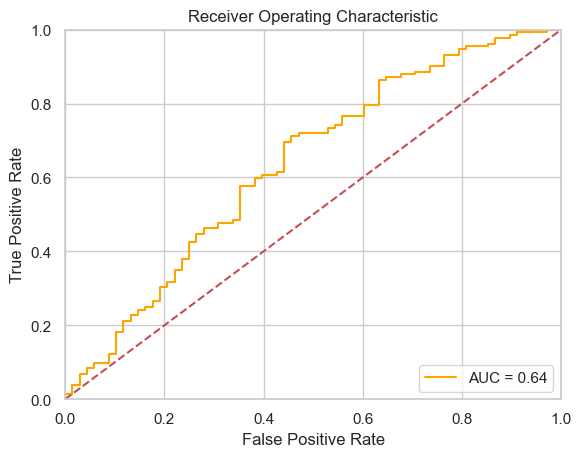

AUC: 0.6883116883116883
Best Threshold=0.695433, G-Mean=0.624

Accuracy: 0.65
Precision: 0.7540983606557377
Recall: 0.696969696969697
F-Measure: 0.7244094488188977


ValueError: Length of values (200) does not match length of index (47)

In [14]:
# init cen_1
normalizer_cen1 = normalize_data(client1_train_x.loc[common_train_index])
model_cen1 = model_cen1 = tf.keras.Sequential([
      normalizer_cen1,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])


epoch_loss=[]
epoch_acc=[]
# custom callback
class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch_loss.append(logs["loss"])
        epoch_acc.append(logs["accuracy"])
        print(f'Epoch {epoch+1}: Loss={logs["loss"]:.4f}, Accuracy={logs["accuracy"]:.4f}')


model_cen1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


# fit1
test_results = {}
cen1_history = model_cen1.fit(client1_train_x, client1_train_y, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[PrintMetricsCallback()])


#evaluate
test_loss, test_acc = model_cen1.evaluate(client1_test_x, client1_test_y, verbose=2)
print('\nTest accuracy:', test_acc)


# result
cen1_pred_test= model_cen1.predict(client1_test_x)

# plot loss
plot_loss(epoch_loss, epoch_acc)
# 計算roc,auc
cen1_fpr_test, cen1_tpr_test, cen1_thresholds_test = roc_curve(client1_test_y, cen1_pred_test[:,1])
auc_cen1 = auc(cen1_fpr_test, cen1_tpr_test)
draw_roc_curve(cen1_fpr_test, cen1_tpr_test,auc=auc_cen1)
print("AUC: {}".format(auc1 ))

# 計算threshold 值

cen1_gmeans_test = np.sqrt(cen1_tpr_test * (1-cen1_fpr_test))
cen1_ix_test = np.argmax(cen1_gmeans_test)
best_threshold_cen1 = cen1_thresholds_test[cen1_ix_test]
print('Best Threshold=%f, G-Mean=%.3f\n' % (cen1_thresholds_test[cen1_ix_test], cen1_gmeans_test[cen1_ix_test]))


# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

plot_accuracy(cen1_pred_test,client1_test_y,best_threshold_cen1)
cen1_pred_test_label = [1 if p >= best_threshold_cen1 else 0 for p in  cen1_pred_test[:,1]]
df['predict_cen1']=cen1_pred_test_label
df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')

In [ ]:
# init cen_2
normalizer_cen2 = normalize_data(client2_train_x.loc[common_train_index])
model_cen2 = tf.keras.Sequential([
      normalizer_cen2,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])

epoch_loss=[]
epoch_acc=[]
# custom callback
class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch_loss.append(logs["loss"])
        epoch_acc.append(logs["accuracy"])
        print(f'Epoch {epoch+1}: Loss={logs["loss"]:.4f}, Accuracy={logs["accuracy"]:.4f}')


model_cen2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


# fit2
test_results = {}
cen2_history = model_cen2.fit(client2_train_x, client2_train_y, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[PrintMetricsCallback()])


#evaluate
test_loss, test_acc = model_cen2.evaluate(client2_test_x, client2_test_y, verbose=2)
print('\nTest accuracy:', test_acc)


# result
cen2_pred_test= model_cen2.predict(client2_test_x)

# plot loss
plot_loss(epoch_loss, epoch_acc)

# 計算roc,auc
cen2_fpr_test, cen2_tpr_test, cen2_thresholds_test = roc_curve(client2_test_y, cen2_pred_test[:,1])
auc_cen2 = auc(cen2_fpr_test, cen2_tpr_test)
draw_roc_curve=draw_roc_curve(cen2_fpr_test, cen2_tpr_test,auc=auc_cen2)
print("AUC: {}".format(auc_cen2 ))

# 計算threshold 值

cen2_gmeans_test = np.sqrt(cen2_tpr_test * (2-cen2_fpr_test))
cen2_ix_test = np.argmax(cen2_gmeans_test)
best_threshold_cen2 = cen2_thresholds_test[cen2_ix_test]
print('Best Threshold=%f, G-Mean=%.3f\n' % (cen2_thresholds_test[cen2_ix_test], cen2_gmeans_test[cen2_ix_test]))

# save result
# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
plot_accuracy(cen2_pred_test,client2_test_y,best_threshold_cen2)
cen2_pred_test_label = [1 if p >= best_threshold_cen2 else 0 for p in  cen2_pred_test[:,1]]
df['predict_cen2']=cen2_pred_test_label
df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')

: 

In [15]:
zip(
        kfold.split(client1_input_index, client1_target_index),
        kfold.split(client2_input_index, client2_target_index))

In [17]:
#vfl
# 設定參數
batch_size = 32
learning_rate = 1e-3
epochs = 20
num_folds = 5 

# merge train and test data
client1_input = pd.concat((client1_train_x,client1_test_x),axis=0)
client2_input = pd.concat((client2_train_x,client2_test_x),axis=0)
client1_target = pd.concat((client1_train_y,client1_test_y),axis=0)
client2_target = pd.concat((client2_train_y,client2_test_y),axis=0)

# get index
client1_input_index = client1_input.index.to_numpy()
client2_input_index = client2_input.index.to_numpy()
client1_target_index = client1_target.index.to_numpy()
client2_target_index = client2_target.index.to_numpy()


# Instantiate an optimizer.
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Instantiate a loss function.
# Not from logits because of the softmax layer converting logits to probability.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# define the kfold cross validation
kfold = KFold(n_splits=num_folds, shuffle=True)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliza  (None, 13)               27        
 tion)                                                           
                                                                 
 dense_39 (Dense)            (None, 128)               1792      
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 128)               16512     
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 2)                 258       
                                                     

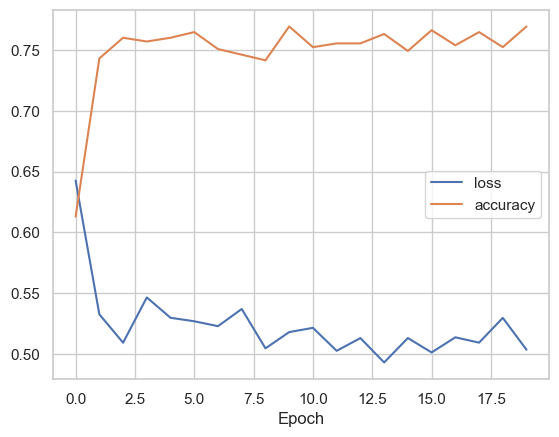

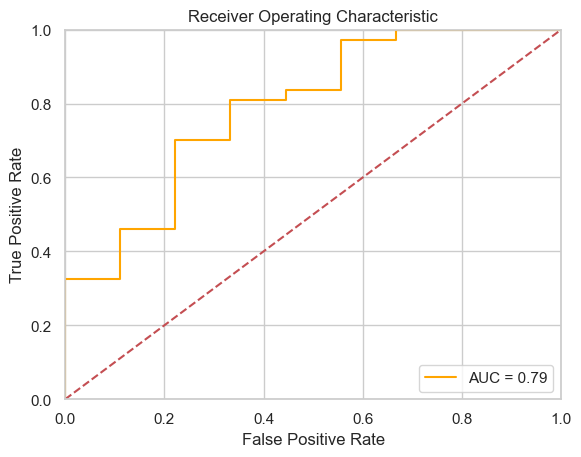

AUC: 0.7897897897897899
Best Threshold=0.644280, G-Mean=0.739

Accuracy: 0.717391304347826
Precision: 0.9285714285714286
Recall: 0.7027027027027027
F-Measure: 0.7999999999999999
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_15 (Normaliza  (None, 13)               27        
 tion)                                                           
                                                                 
 dense_45 (Dense)            (None, 128)               1792      
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_46 (Dense)            (None, 128)               16512     
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
       

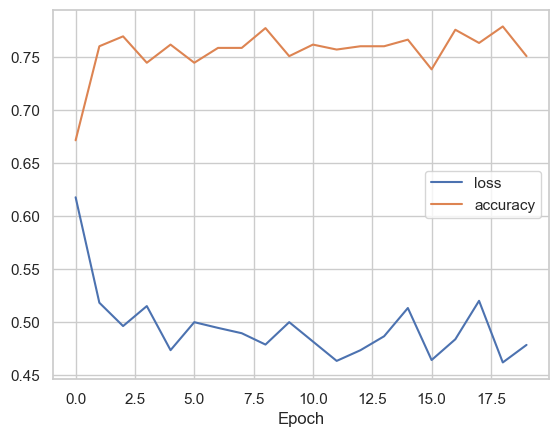

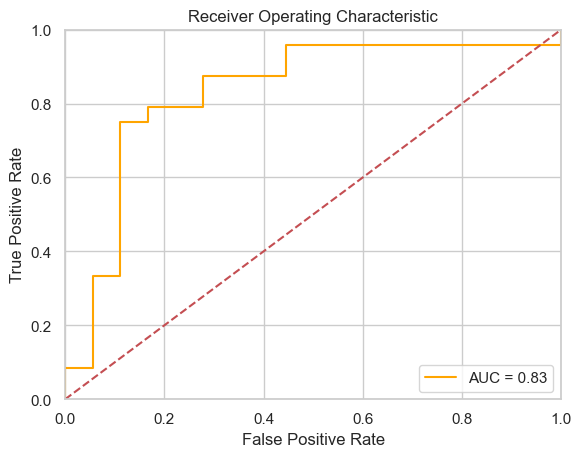

AUC: 0.8310185185185186
Best Threshold=0.773345, G-Mean=0.816

Accuracy: 0.8095238095238095
Precision: 0.9
Recall: 0.75
F-Measure: 0.8181818181818182
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_17 (Normaliza  (None, 13)               27        
 tion)                                                           
                                                                 
 dense_51 (Dense)            (None, 128)               1792      
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 128)               16512     
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                   

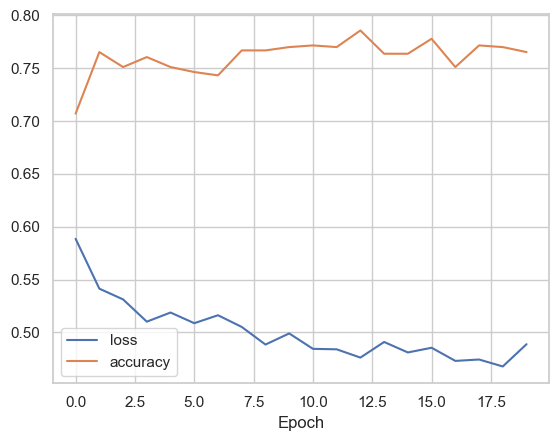

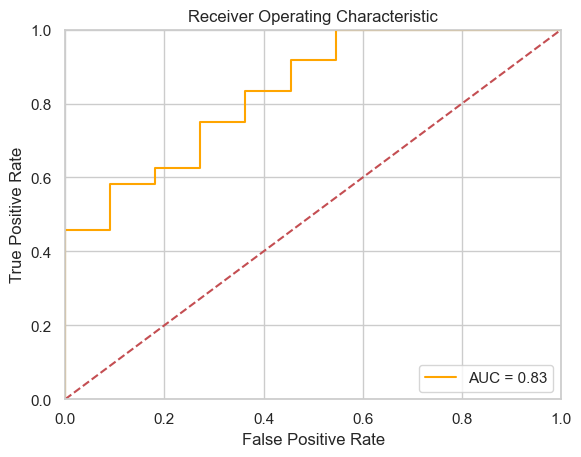

AUC: 0.8333333333333333
Best Threshold=0.736602, G-Mean=0.739

Accuracy: 0.7428571428571429
Precision: 0.8571428571428571
Recall: 0.75
F-Measure: 0.7999999999999999
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_19 (Normaliza  (None, 13)               27        
 tion)                                                           
                                                                 
 dense_57 (Dense)            (None, 128)               1792      
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_58 (Dense)            (None, 128)               16512     
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                    

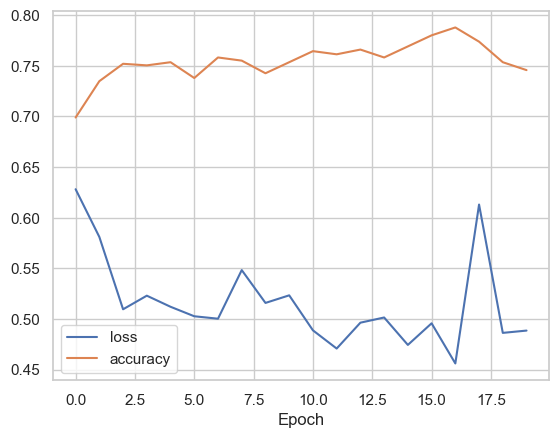

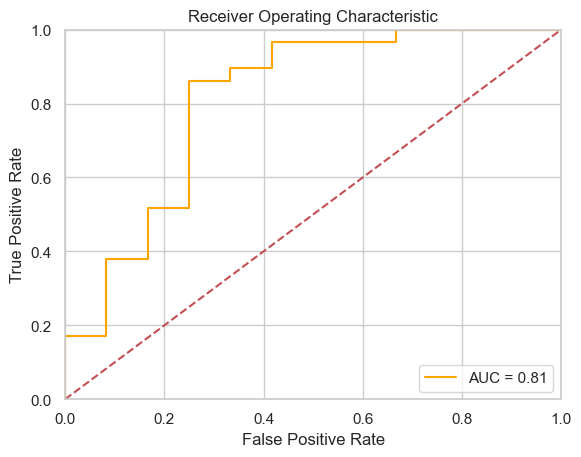

AUC: 0.8103448275862069
Best Threshold=0.619632, G-Mean=0.804

Accuracy: 0.8292682926829268
Precision: 0.8928571428571429
Recall: 0.8620689655172413
F-Measure: 0.8771929824561403
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_21 (Normaliza  (None, 13)               27        
 tion)                                                           
                                                                 
 dense_63 (Dense)            (None, 128)               1792      
                                                                 
 dropout_42 (Dropout)        (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 128)               16512     
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
      

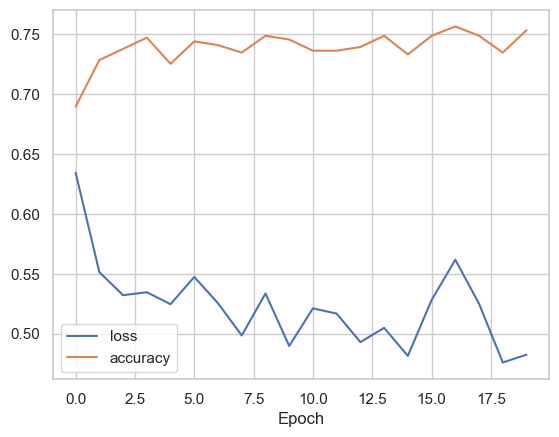

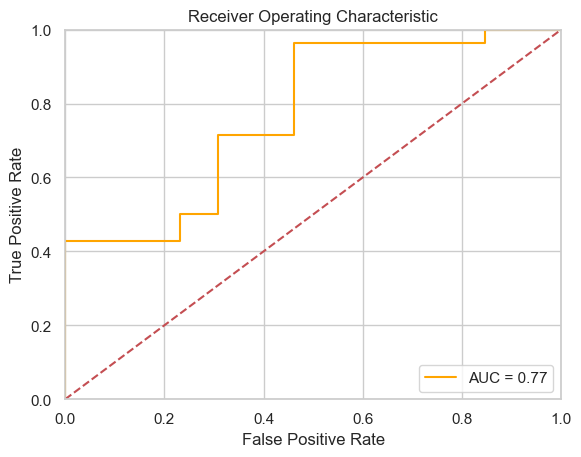

AUC: 0.771978021978022
Best Threshold=0.513893, G-Mean=0.721

Accuracy: 0.8292682926829268
Precision: 0.8181818181818182
Recall: 0.9642857142857143
F-Measure: 0.8852459016393442


In [18]:
# kfold cross validation evaluation of a model


for (cen1_train_index, cen1_test_index), (cen2_train_index, cen2_test_index) in zip(
        kfold.split(client1_input_index, client1_target_index),
        kfold.split(client2_input_index, client2_target_index)):
  
  # index
  cen1_train_x_index = client1_input_index[cen1_train_index]
  cen2_train_x_index = client2_input_index[cen2_train_index]
  
  cen1_test_x_index = client1_input_index[cen1_test_index]
  cen2_test_x_index = client2_input_index[cen2_test_index]
  
  cen1_train_y_index = client1_target_index[cen1_train_index]
  cen2_train_y_index = client2_target_index[cen2_train_index]
  
  cen1_test_y_index = client1_target_index[cen1_test_index]
  cen2_test_y_index = client2_target_index[cen2_test_index]
  
  
  # define train,test x use index
  client1_train_x_k = client1_input[client1_input.index.isin(cen1_train_x_index)]
  client2_train_x_k = client2_input[client2_input.index.isin(cen2_train_x_index)]
  
  client1_test_x_k = client1_input[client1_input.index.isin(cen1_test_x_index)]
  client2_test_x_k = client2_input[client2_input.index.isin(cen2_test_x_index)]

  client1_train_y_k = client1_target[client1_target.index.isin(cen1_train_y_index)]
  client2_train_y_k = client2_target[client2_target.index.isin(cen2_train_y_index)]
  
  client1_test_y_k = client1_target[client1_target.index.isin(cen1_test_y_index)]
  client2_test_y_k = client2_target[client2_target.index.isin(cen2_test_y_index)]
  

  common_train_index_k = np.intersect1d(cen1_train_x_index,cen2_train_x_index)
  common_test_index_k = np.intersect1d(cen1_test_x_index,cen2_test_x_index)
  
  
  #init model
  normalizer1 = normalize_data(client1_train_x_k.loc[common_train_index_k])
  model1 =   tf.keras.Sequential([
        normalizer1,
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(2),
        layers.Softmax()])
  model1.summary()
  client1 = Client( client1_train_x_k, client1_train_y_k,client1_test_x_k,client1_test_y_k, False,model1)


  normalizer2 = normalize_data(client2_train_x_k.loc[common_train_index_k])
  model2 = tf.keras.Sequential([
        normalizer2,
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(2),
        layers.Softmax()])
  client2 = Client(client2_train_x_k, client2_train_y_k,client2_test_x_k,client2_test_y_k, True,model2)

  # train_on_client
  common_train_index_list_k = common_train_index_k.tolist()
  epoch_loss = []
  epoch_acc = []

  for epoch in range(epochs):
      print(f'run in {epoch} epoch')
      # epoch=0
      random.shuffle(common_train_index_list_k)
      train_index_batches = [common_train_index_list_k[i:i + batch_size] for i in range(0, len(common_train_index_list_k), batch_size)] 
      total_loss = 0.0
      # Iterate over the batches of the dataset.
      for step, batch_index in enumerate(train_index_batches):
          
          partial_grads = client1.next_batch(batch_index)
          client2.next_batch(batch_index)

          prob, loss_value = client2.loss_and_update(client1.cal_model())
          grad = client2.assemble_grad(partial_grads)
          client1.update_with(grad)
          
          total_loss = loss_value + total_loss
          train_acc_metric.update_state(client2.batch_answers(), prob)
      train_acc = train_acc_metric.result()
      print(f'-----train accuracy{train_acc}-----')
      train_acc_metric.reset_states()
      epoch_loss.append((total_loss)/(step + 1))
      epoch_acc.append(train_acc)

  plot_loss(epoch_loss, epoch_acc)

  # 預測結果
  vfl_pred_test = (client1.predict(common_test_index_k) + client2.predict(common_test_index_k))/2

  # 計算roc,auc
  vfl_fpr_test, vfl_tpr_test, vfl_thresholds_test = roc_curve(client2.test_answers(common_test_index_k), vfl_pred_test[:,1])
  auc1 = auc(vfl_fpr_test, vfl_tpr_test)
  draw_roc_curve(vfl_fpr_test, vfl_tpr_test,auc1)
  print("AUC: {}".format(auc1 ))

  # 計算threshold 值
  vfl_gmeans_test = np.sqrt(vfl_tpr_test * (1-vfl_fpr_test))
  vfl_ix_test = np.argmax(vfl_gmeans_test)
  best_threshold = vfl_thresholds_test[vfl_ix_test]
  print('Best Threshold=%f, G-Mean=%.3f\n' % (vfl_thresholds_test[vfl_ix_test], vfl_gmeans_test[vfl_ix_test]))

  # 準確率
  plot_accuracy(vfl_pred_test, client2.test_answers(common_test_index_k), best_threshold)

  # save result
  df=pd.DataFrame(client2.test_answers(common_test_index_k))
  vfl_pred_test_label = [1 if p >= best_threshold else 0 for p in  vfl_pred_test[:,1]]
  df['predict']=vfl_pred_test_label
  df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')
  #evalueate